<a href="https://colab.research.google.com/github/KThirukkumar/freeCodeCamp-machinelearning/blob/main/SMS_Text_Classification/fcc_sms_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries
try:
  # %tensorflow_version only exists in Colab.
  !pip install tf-nightly
except Exception:
  pass
import tensorflow as tf
import pandas as pd
from tensorflow import keras
!pip install tensorflow-datasets
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 551.1 MB 24 kB/s 
     |████████████████████████████████| 5.6 MB 1.5 MB/s 
     |████████████████████████████████| 1.7 MB 40.9 MB/s 
     |████████████████████████████████| 439 kB 58.5 MB/s 
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires flatbuffers<2,>=1.12, but you have flatbuffers 22.11.23 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2.12.0-dev20221127


In [ ]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

--2022-11-28 06:18:04--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 104.26.3.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358233 (350K) [text/tab-separated-values]
Saving to: ‘train-data.tsv’

train-data.tsv      100%[===================>] 349.84K  --.-KB/s    in 0.04s   

2022-11-28 06:18:04 (8.08 MB/s) - ‘train-data.tsv’ saved [358233/358233]

--2022-11-28 06:18:04--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 104.26.3.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118774 (116K) [text/tab-separated-values]
Saving to: ‘valid-data.tsv’

valid-data.tsv      100%[==============

In [ ]:
#load train data to dataframe and check contents
with open('train-data.tsv') as file:
  train_df = pd.read_csv(file, sep = '\t', header = None)
train_df.head()

,0,1
0,ham,ahhhh...just woken up!had a bad dream about u ...
1,ham,you can never do nothing
2,ham,"now u sound like manky scouse boy steve,like! ..."
3,ham,mum say we wan to go then go... then she can s...
4,ham,never y lei... i v lazy... got wat? dat day ü ...


In [ ]:
#load validation data to dataframe and check contents
with open('valid-data.tsv') as file:
  val_df = pd.read_csv(file, sep = '\t', header = None)
val_df.head()

,0,1
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?


In [ ]:
#check for null values and drop
b = (train_df.isnull().sum())
train_df = train_df.dropna()
a = (train_df.isnull().sum())
print(f"dropped {b[1]-a[1]} null values")

dropped 0 null values


In [ ]:
#check properties of labels (confirm 2 unique) and features
train_df.groupby(0).describe().T

0                            ham  \
1 count                     3619   
  unique                    3430   
  top     sorry, i'll call later   
  freq                        22   

0                                                      spam  
1 count                                                 560  
  unique                                                505  
  top     hmv bonus special 500 pounds of genuine hmv vo...  
  freq                                                    3

In [ ]:
#drop duplicated data in the majority class (with scikit, etc. more entries could be removed by jaccard or hamming distance)
temp = train_df.drop((train_df[train_df.duplicated()][train_df[train_df.duplicated()][0] == 'ham']).index)
print(f'removed {train_df.shape[0] - temp.shape[0]} duplicates from majority class')

removed 189 duplicates from majority class


In [ ]:
#undersample majority class or oversample minority class
#note that these implementations should introduce some underfitting and overfitting, respectively. With imblearn, etc. these issues can be partially resolved by oversampling with synthetic data instead.
majority_ratio = 1.5
sampling = 'over'

ham, spam = temp[0].value_counts()
ham_under = temp[temp[0] == 'ham'].sample(int(spam*majority_ratio))
# spam_over = temp[temp[0] == 'spam'].sample(int(ham/majority_ratio), replace = True)
spam_over = pd.concat([temp[temp[0] == 'spam'], temp[temp[0] == 'spam'].sample(int(ham/majority_ratio-spam), replace = True)])

if sampling == 'over':
  temp = pd.concat([spam_over,temp[temp[0] == 'ham']])
elif sampling == 'under':
  temp = pd.concat([ham_under,temp[temp[0] == 'spam']])
else:
  print('sampling method unspecified. using undersampling')
  temp = pd.concat([ham_under,temp[temp[0] == 'spam']])  

temp.groupby(0).describe().T

0                                                       ham  \
1 count                                                3430   
  unique                                               3430   
  top     ahhhh...just woken up!had a bad dream about u ...   
  freq                                                    1   

0                                                      spam  
1 count                                                2286  
  unique                                                505  
  top     well done england! get the official poly ringt...  
  freq                                                   15

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


appropriate max sequence length: 41.0


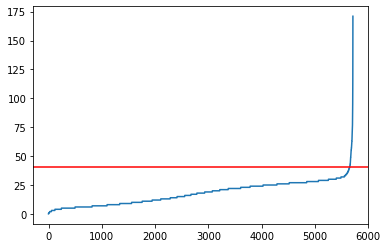

In [ ]:
#plot sequence lengths to determine appropriate sequence length for model

ax = temp[1].str.replace(r'[^\w\s]+', '').str.split().str.len().sort_values().plot(use_index = False)
seq_quant = temp[1].str.replace(r'[^\w\s]+', '').str.split().str.len().sort_values().quantile(.99)
ax.axhline(y = seq_quant, color = 'r')
print (f'appropriate max sequence length: {seq_quant}')

In [ ]:
#get top 20 most frequent words to inform preprocessing
temp[1].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).sort_values(ascending = False)[:20]

to      3202.0
you     1961.0
a       1844.0
i       1637.0
the     1426.0
call    1131.0
your    1128.0
for     1034.0
and      960.0
is       949.0
u        907.0
or       785.0
in       771.0
on       721.0
2        683.0
of       642.0
have     640.0
ur       616.0
free     596.0
my       544.0
dtype: float64

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


appropriate vocab size: 4378


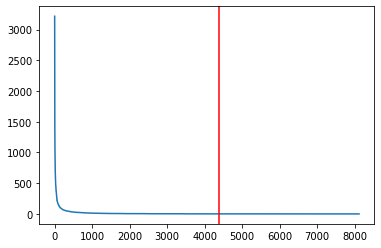

In [ ]:
#plot word frequency and determine appropriate vocab size
#note that this should have minimal impact on this size of dataset, but is good practice 
ax = temp[1].str.replace(r'[^\w\s]+', '').str.split().explode().value_counts().plot(use_index = False)
freq_vocab = temp[1].str.replace(r'[^\w\s]+', '').str.split().explode().value_counts().loc[lambda x: x>1]
ax.axvline(x = freq_vocab.shape[0], color = 'r')
print (f'appropriate vocab size: {freq_vocab.shape[0]}')

In [ ]:
#function to convert df to ds, one-hot encoding the labels
label2int = {"ham": 0, "spam": 1}
int2label = {0: "ham", 1: "spam"}
def df_to_dataset(dataframe, batch_size=128):
  dataframe = temp.copy()
  y = dataframe.pop(0)
  dataframe = dataframe[1].tolist()
  labels = y.map(label2int)
  labels = keras.utils.to_categorical(labels)
  ds = tf.data.Dataset.from_tensor_slices((dataframe, labels)).batch(
     128)
  return ds

In [ ]:
#create batched train and val datasets, then preview
train_ds = df_to_dataset(temp)
val_ds = df_to_dataset(val_df)
for text_batch, label_batch in train_ds.take(1):
  for i in range(5):
    print(label_batch[i].numpy(),text_batch.numpy()[i])

[0. 1.] b'urgent! call 09066350750 from your landline. your complimentary 4* ibiza holiday or 10,000 cash await collection sae t&cs po box 434 sk3 8wp 150 ppm 18+'
[0. 1.] b'bored housewives! chat n date now! 0871750.77.11! bt-national rate 10p/min only from landlines!'
[0. 1.] b'message important information for o2 user. today is your lucky day! 2 find out why log onto http://www.urawinner.com there is a fantastic surprise awaiting you'
[0. 1.] b'free for 1st week! no1 nokia tone 4 ur mobile every week just txt nokia to 8077 get txting and tell ur mates. www.getzed.co.uk pobox 36504 w45wq 16+ norm150p/tone'
[0. 1.] b'you have 1 new voicemail. please call 08719181503'


In [ ]:
#configure for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
#create vectorization layer

#custom preprocessing function
stopwords = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]
pattern = r'\b(' + r'|'.join(stopwords) + r')\b'
def custom_standardization(input_data):
  clean = tf.strings.lower(input_data) #make all lowercase
  clean = tf.strings.regex_replace(clean, '<br />', ' ') #remove html
  clean = tf.strings.regex_replace(clean, r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''',' ') #remove links
  clean = tf.strings.regex_replace(clean, '\w*\d\w*', ' ') #remove numbers and words with numbers
  clean = tf.strings.regex_replace(clean, '[^ a-z]', ' ') #remove remaining noncharacters
  clean = tf.strings.regex_replace(clean, pattern, '') #remove stopwords
  clean = tf.strings.regex_replace(clean, '\\s+', ' ') #fix extra spaces
  clean = tf.strings.strip(clean)
  return clean

#hyperparams estimated from above, but optimal values can be found empirically if desired
vocab_size = 4000
sequence_length = 50

#note that standardization, padding/truncating is built-in
vectorize_layer = tf.keras.layers.TextVectorization(
    # standardize='lower_and_strip_punctuation',
    standardize = custom_standardization,
    max_tokens=vocab_size,
    split='whitespace',
    output_mode='int',
    output_sequence_length=sequence_length)

#adapt layer to the training data (without labels)
train_text = train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
#function to check vectorization layer preprocessing
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [ ]:
#check preprocessing
text_batch, label_batch = next(iter(train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Standardized Review", custom_standardization(first_review))
print("Vectorized Review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'urgent! call 09066350750 from your landline. your complimentary 4* ibiza holiday or 10,000 cash await collection sae t&cs po box 434 sk3 8wp 150 ppm 18+', shape=(), dtype=string)
Standardized Review tf.Tensor(b'urgent call landline complimentary ibiza holiday cash await collection sae cs po box ppm', shape=(), dtype=string)
Vectorized Review (<tf.Tensor: shape=(1, 50), dtype=int64, numpy=
array([[ 44,   2,  94, 299, 709,  77,  23, 166, 115, 147,  66,  98,  95,
        773,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])>, <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0., 1.], dtype=float32)>)


In [ ]:
vocab_size = vocab_size
embedding_dim=16
n_lstm = 128
lstm_drop = 0.2
dropout = 0.1

model = keras.models.Sequential([
  vectorize_layer,
  keras.layers.Embedding(vocab_size, embedding_dim),
  keras.layers.Bidirectional(keras.layers.LSTM(n_lstm, recurrent_dropout = lstm_drop, return_sequences = False)),
  # keras.layers.LSTM(n_lstm, recurrent_dropout = lstm_drop, return_sequences = True),
  keras.layers.Dropout(dropout),
  keras.layers.Dense(2, activation="softmax")
])

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy',keras.metrics.Precision(), keras.metrics.Recall()])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 50)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 50, 16)            64000     
                                                                 
 bidirectional (Bidirectiona  (None, 256)              148480    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 2)                 514       
                                                                 
Total params: 212,994
Trainable params: 212,994
Non-trai

In [ ]:
epochs = 15
stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 2)
history = model.fit(train_ds, epochs = epochs, validation_data = val_ds, callbacks = [stop], verbose = 2)

Epoch 1/15
45/45 - 43s - loss: 2.4784 - accuracy: 0.6585 - precision: 0.6585 - recall: 0.6585 - val_loss: 1.2489 - val_accuracy: 0.6001 - val_precision: 0.6001 - val_recall: 0.6001 - 43s/epoch - 949ms/step
Epoch 2/15
45/45 - 33s - loss: 1.1634 - accuracy: 0.5689 - precision: 0.5689 - recall: 0.5689 - val_loss: 0.6868 - val_accuracy: 0.6001 - val_precision: 0.6001 - val_recall: 0.6001 - 33s/epoch - 725ms/step
Epoch 3/15
45/45 - 30s - loss: 0.7588 - accuracy: 0.5868 - precision: 0.5868 - recall: 0.5868 - val_loss: 0.6148 - val_accuracy: 0.6001 - val_precision: 0.6001 - val_recall: 0.6001 - 30s/epoch - 671ms/step
Epoch 4/15
45/45 - 31s - loss: 0.5985 - accuracy: 0.7003 - precision: 0.7003 - recall: 0.7003 - val_loss: 0.8710 - val_accuracy: 0.6001 - val_precision: 0.6001 - val_recall: 0.6001 - 31s/epoch - 687ms/step
Epoch 5/15
45/45 - 30s - loss: 0.4297 - accuracy: 0.8576 - precision: 0.8576 - recall: 0.8576 - val_loss: 0.1427 - val_accuracy: 0.9718 - val_precision: 0.9718 - val_recall: 0.

In [ ]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
  prediction = model.predict([pred_text])
  return [np.max(prediction),int2label[np.argmax(prediction)]]
  # return [prediction[np.argmax(prediction)], int2label[np.argmax(prediction)]]

pred_text = "sale today! to stop texts call"
prediction = predict_message(pred_text)
print(prediction)

1/1 [==============================] - 1s 788ms/step
[0.9342076, 'spam']


In [ ]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


1/1 [==============================] - 0s 64ms/step
You passed the challenge. Great job!
